In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5gk1968h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5gk1968h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Load CLIP model and preprocessing function
model, preprocess = clip.load("ViT-B/32", device=device)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Define transform (resize for CLIP)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

# Load subset of CIFAR-10 (e.g., first 200 images)
dataset = CIFAR10(root="./data", train=False, download=True)
images = [transform(dataset[i][0]) for i in range(200)]
image_labels = [dataset[i][1] for i in range(200)]
original_images = [dataset[i][0] for i in range(200)]  # for display


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 195MiB/s]
100%|██████████| 170M/170M [00:01<00:00, 90.2MB/s]


In [3]:
# Stack all image tensors into a batch
image_batch = torch.stack(images).to(device)

# Generate CLIP image embeddings
with torch.no_grad():
    image_embeddings = model.encode_image(image_batch).float()
    image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

# Generate CLIP text embeddings (class names)
text_tokens = clip.tokenize(class_names).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).float()
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)


In [4]:
# Define CIFAR-10 classes
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


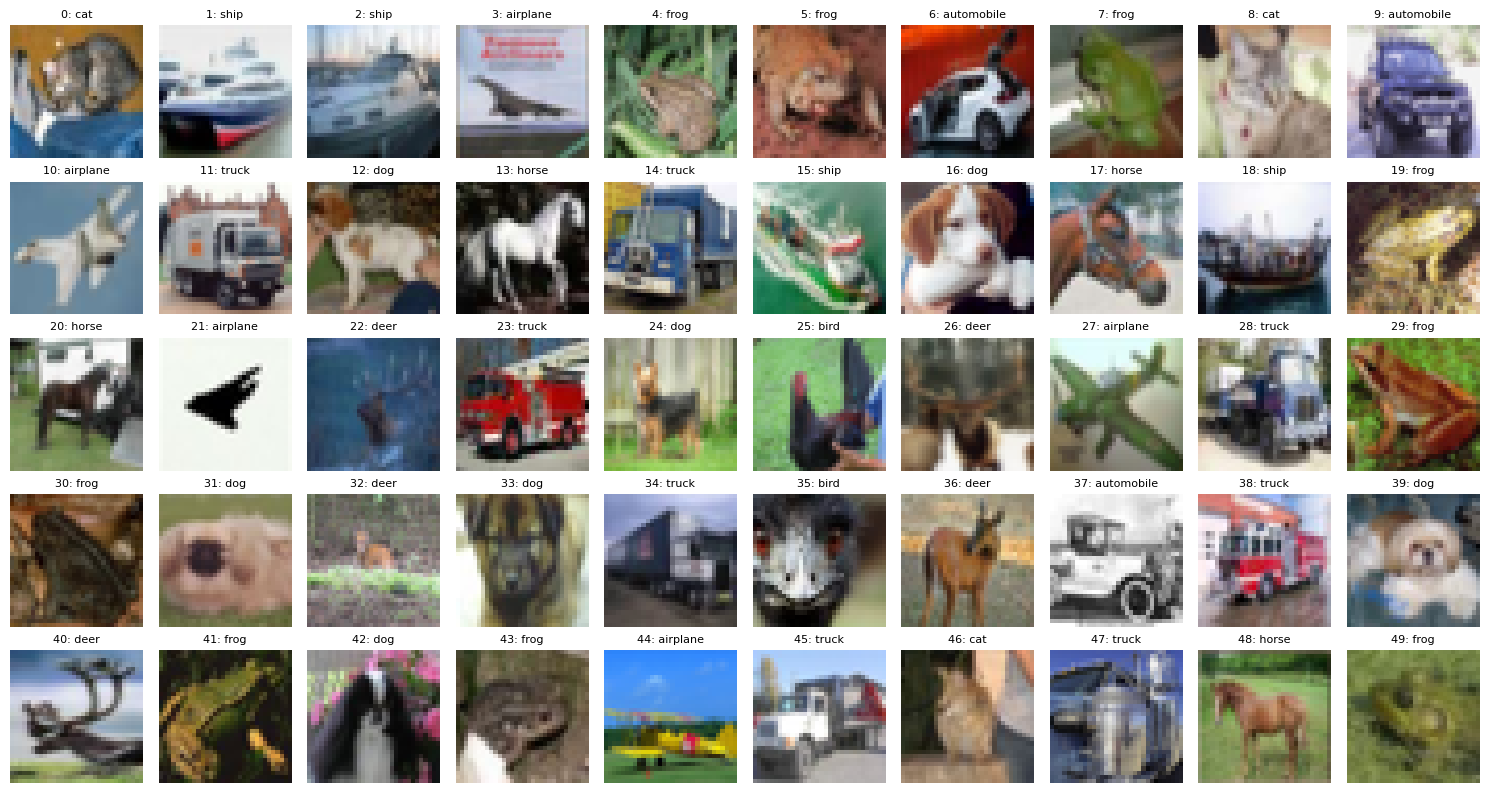

In [5]:
def show_image_grid(images, labels, rows=5, cols=10):
    fig, axs = plt.subplots(rows, cols, figsize=(15, 8))
    for i in range(rows * cols):
        axs[i // cols, i % cols].imshow(images[i])
        axs[i // cols, i % cols].axis('off')
        axs[i // cols, i % cols].set_title(f"{i}: {class_names[labels[i]]}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Visualize first 50 images with index
show_image_grid(original_images, image_labels, rows=5, cols=10)


Choose search type:
1. Image-to-Image
2. Text-to-Image
Enter 1 or 2: 2

📝 Enter your text query (e.g., 'a dog', 'an airplane'): pen

🔍 Top-5 images matching: "pen"


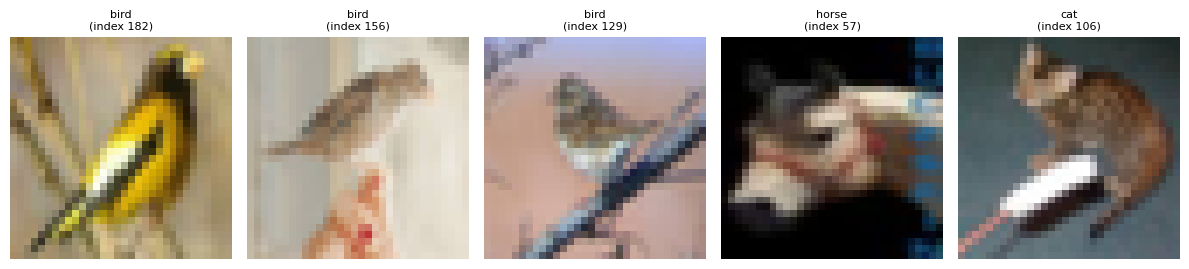

In [13]:

import io
from google.colab import files

choice = input("Choose search type:\n1. Image-to-Image\n2. Text-to-Image\nEnter 1 or 2: ").strip()

if choice == '1':
    # 🔁 IMAGE-TO-IMAGE SEARCH
    print("\n📤 Upload an image to find visually similar CIFAR-10 images.")
    uploaded = files.upload()

    for filename in uploaded.keys():
        uploaded_image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
        uploaded_image = uploaded_image.resize((224, 224))
        display(uploaded_image)

        # Preprocess uploaded image
        image_tensor = preprocess_transform(uploaded_image).unsqueeze(0).to(device)

        # Encode uploaded image
        with torch.no_grad():
            uploaded_embedding = model.encode_image(image_tensor).float()
            uploaded_embedding /= uploaded_embedding.norm(dim=-1, keepdim=True)

        # Find most similar CIFAR-10 images
        similarities = (uploaded_embedding @ image_embeddings.T).squeeze(0)
        topk = 5
        top_indices = similarities.topk(topk).indices.cpu().numpy()

        print(f"\n🔍 Top-{topk} similar CIFAR-10 images:")
        plt.figure(figsize=(12, 3))
        for i, idx in enumerate(top_indices):
            plt.subplot(1, topk, i+1)
            plt.imshow(original_images[idx])
            plt.title(f"{class_names[image_labels[idx]]}\n(index {idx})", fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

elif choice == '2':
    # 🔁 TEXT-TO-IMAGE SEARCH
    query = input("\n📝 Enter your text query (e.g., 'a dog', 'an airplane'): ")

    # Tokenize and encode the query
    text_token = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_token).float()
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

    # Find most relevant CIFAR-10 images
    similarities = (text_embedding @ image_embeddings.T).squeeze(0)
    topk = 5
    top_indices = similarities.topk(topk).indices.cpu().numpy()

    print(f"\n🔍 Top-{topk} images matching: \"{query}\"")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, topk, i+1)
        plt.imshow(original_images[idx])
        plt.title(f"{class_names[image_labels[idx]]}\n(index {idx})", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("❌ Invalid option. Please enter 1 or 2.")



🎯 Custom Text-to-Image Accuracy: 80.00%


,Text Query,True Label,Predicted Label,Correct
0,a red car,automobile,automobile,True
1,a dog running,dog,bird,False
2,a ship in the ocean,ship,ship,True
3,a bird flying in the sky,bird,bird,True
4,a cat sitting,cat,cat,True


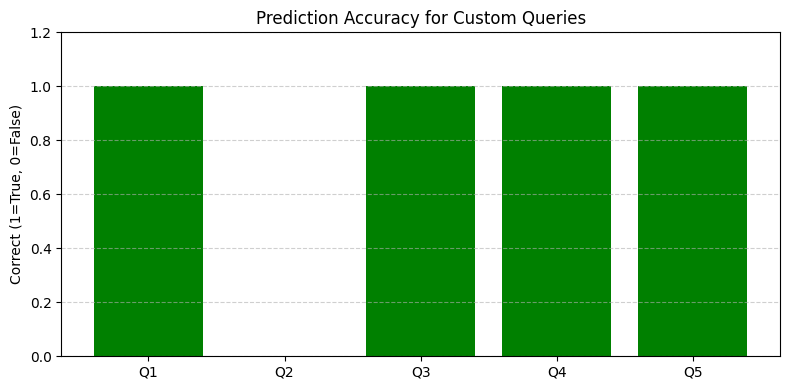

NameError: name 'calculate_fid' is not defined

In [14]:
import pandas as pd
# 📥 Custom Text Queries and Ground Truth Labels (you provide these)
custom_texts = [
    "a red car",
    "a dog running",
    "a ship in the ocean",
    "a bird flying in the sky",
    "a cat sitting"
]
true_labels = ["automobile", "dog", "ship", "bird", "cat"]  # ground truth class names

# Define CIFAR-10 classes
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 🧠 Get predictions
def compute_custom_accuracy(text_queries, true_labels, topk=1):
    correct = 0
    preds = []
    top_indices = []
    for i, text in enumerate(text_queries):
        token = clip.tokenize([text]).to(device)
        with torch.no_grad():
            text_embed = model.encode_text(token).float()
            text_embed /= text_embed.norm(dim=-1, keepdim=True)
        sims = (text_embed @ image_embeddings.T).squeeze(0)
        idx = sims.topk(topk).indices[0].item()
        pred_label = cifar10_classes[image_labels[idx]]  # Fix: use cifar10_classes to map to label
        preds.append(pred_label)
        top_indices.append(idx)
        if pred_label == true_labels[i]:
            correct += 1
    return correct / len(text_queries), preds, top_indices

# 🎯 Run Evaluation
accuracy, predicted_labels, matched_indices = compute_custom_accuracy(custom_texts, true_labels)
print(f"\n🎯 Custom Text-to-Image Accuracy: {accuracy * 100:.2f}%")

# 📋 Table of Predictions
results_df = pd.DataFrame({
    "Text Query": custom_texts,
    "True Label": true_labels,
    "Predicted Label": predicted_labels,
    "Correct": [t == p for t, p in zip(true_labels, predicted_labels)]
})
display(results_df)

# 📈 Bar Plot of Prediction Correctness
plt.figure(figsize=(8, 4))
correct = results_df['Correct'].values
plt.bar(range(len(custom_texts)), correct, tick_label=[f"Q{i+1}" for i in range(len(custom_texts))],
        color=['green' if c else 'red' for c in correct])
plt.ylabel("Correct (1=True, 0=False)")
plt.title("Prediction Accuracy for Custom Queries")
plt.ylim(0, 1.2)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 📏 FID Score
matched_embeddings = image_embeddings[matched_indices].cpu().numpy()
fid_score = calculate_fid(matched_embeddings, image_embeddings.cpu().numpy())
print(f"\n📏 FID Score (custom queries vs. full CIFAR set): {fid_score:.2f}")

# 🖼️ Qualitative Image Grid
plt.figure(figsize=(15, 6))
for i, idx in enumerate(matched_indices):
    plt.subplot(1, len(custom_texts), i+1)
    plt.imshow(original_images[idx])
    plt.title(f"Q{i+1}: {predicted_labels[i]}", fontsize=8)
    plt.axis("off")
plt.suptitle("Matched Images for Custom Queries", fontsize=14)
plt.tight_layout()
plt.show()

# 🧾 Summary
print("\n📊 Custom Query Evaluation Summary:")
print(f"- Accuracy: {accuracy * 100:.2f}%")
print(f"- FID Score (vs. full CIFAR): {fid_score:.2f}")

